In [1]:
import numpy as np 
import os 
import sys
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns
!pip install opendatasets --quiet
import opendatasets as od 
import plotly.express as px
%matplotlib inline

In [2]:
test_url='https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp?select=test.txt'
train_url='https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp?select=train.txt'
val_url='https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp?select=val.txt'

In [ ]:
od.download(test_url,force=True)

# 5490852669ad9c33eec8a823666c601f


In [4]:
from wordcloud import WordCloud
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

In [5]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout

In [6]:
!pip install transformers --quiet

     |████████████████████████████████| 4.2 MB 8.0 MB/s 
     |████████████████████████████████| 596 kB 47.3 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 6.6 MB 38.6 MB/s 


In [7]:
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup

In [8]:
# Performing Basic and simple model prediction

In [12]:
test_data = pd.read_csv("/content/emotions-dataset-for-nlp/test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("/content/emotions-dataset-for-nlp/train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("/content/emotions-dataset-for-nlp/val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
print("Train : ", train_data.shape)
print("Test : ", test_data.shape)
print("Validation : ", validation_data.shape)

Train :  (16000, 2)
Test :  (2000, 2)
Validation :  (2000, 2)


In [13]:
train_data.head(5)

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [14]:
# Finding the length of the comments just to see whether it is corerelated to the emotion or not;

In [15]:
train_data['length'] = [len(x) for x in train_data['Comment']]
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


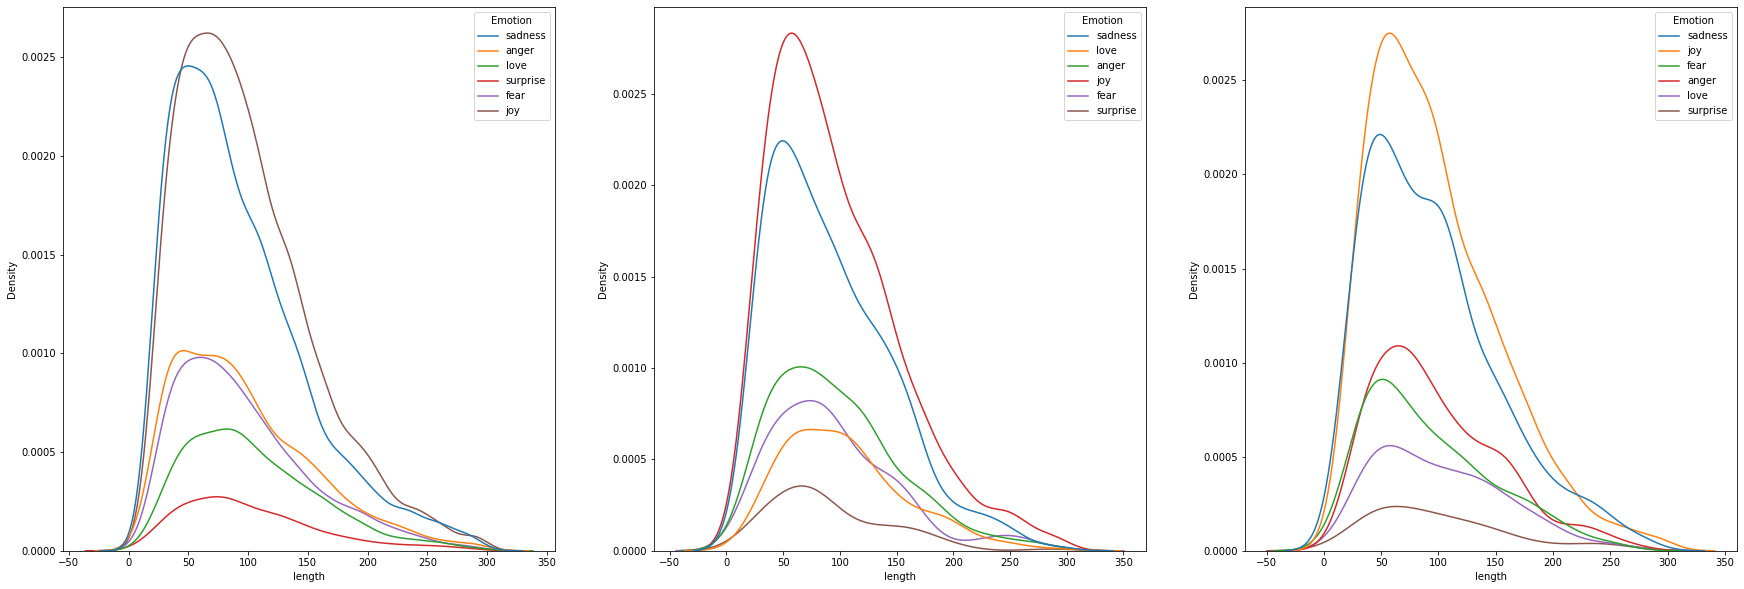

In [16]:
all_data = {'Train Data': train_data, 'Validation Data': validation_data, 'Test Data': test_data}
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i, df in enumerate(all_data.values()):
    df2 = df.copy()
    df2['length'] = [len(x) for x in df2['Comment']]
    sns.kdeplot(data=df2,x='length',hue='Emotion', ax=ax[i])
plt.show()

In [17]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    plt.axis("off");

In [18]:
# Creating a wordcloud for each emotion

In [19]:
emotions_list = train_data['Emotion'].unique()
emotions_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

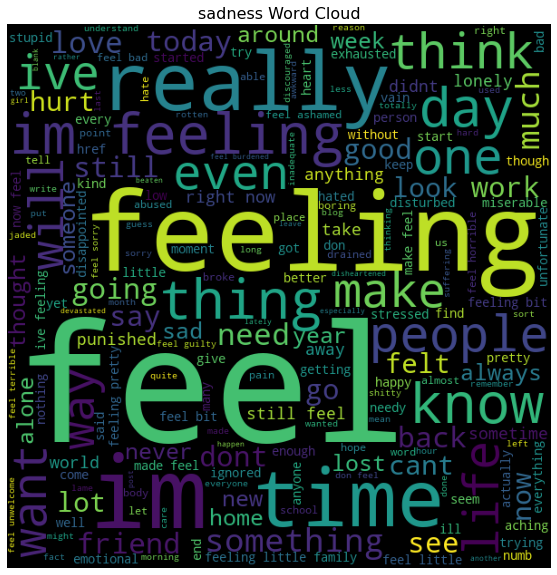

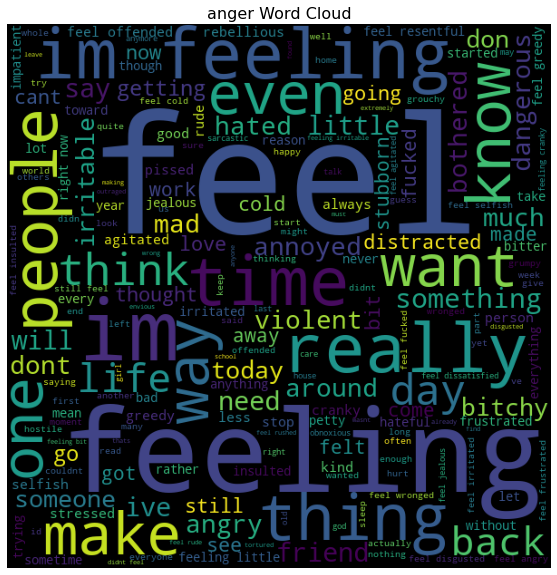

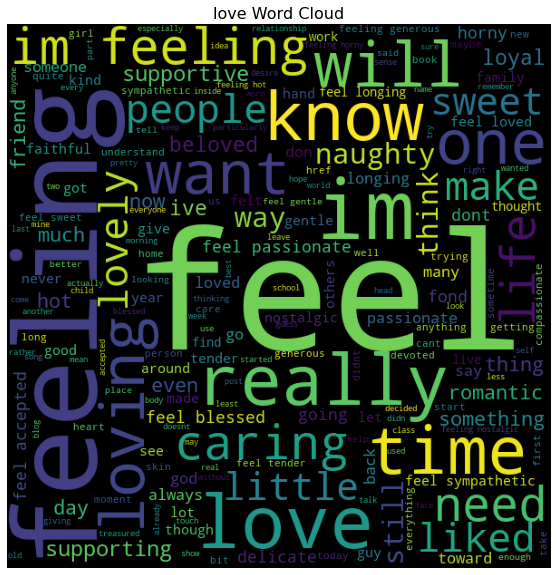

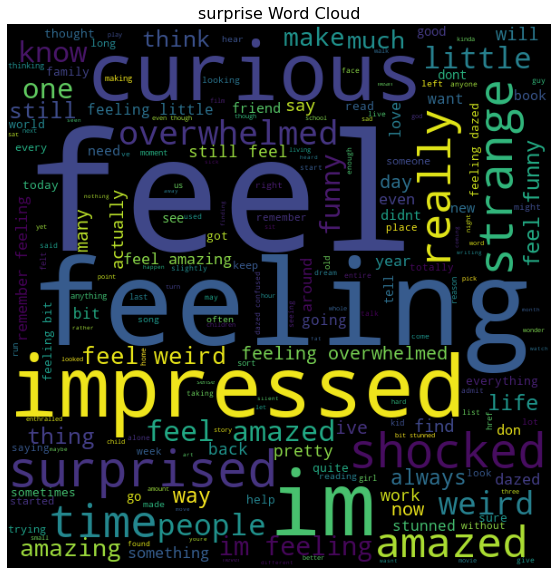

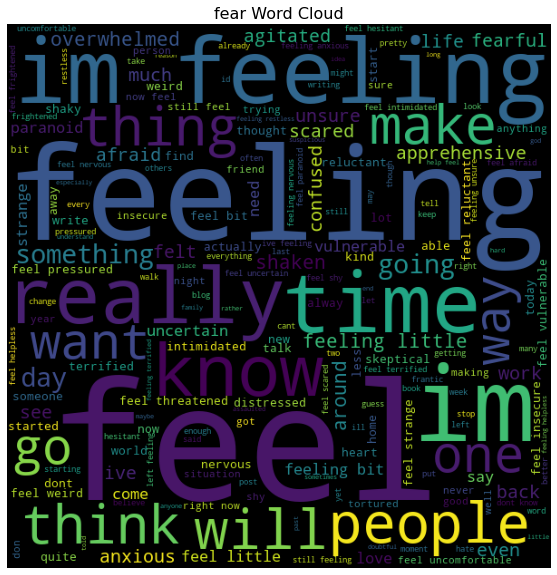

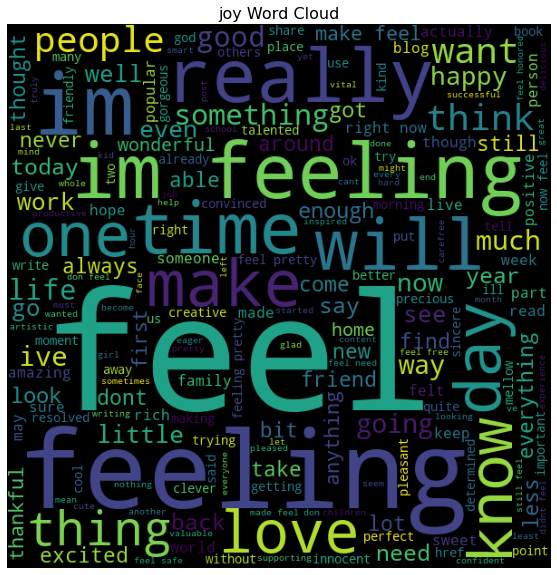

In [20]:
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

In [21]:
# Preprocessing

In [22]:
# Label Encoding
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])
test_data['Emotion'] = lb.fit_transform(test_data['Emotion'])
validation_data['Emotion'] = lb.fit_transform(validation_data['Emotion'])

In [23]:
train_data.head(5)

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [24]:
# Cleaning comments by removing stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
max_len=train_data['length'].max()
max_len

300

In [26]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(pd.concat(X_train, axis=0))
vocabSize = 11000

In [27]:
from tensorflow.keras.preprocessing.text import one_hot


In [28]:
def text_cleaning(df, column):
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    print(pad.shape)
    return pad

In [29]:
x_train = text_cleaning(train_data, "Comment")
x_test = text_cleaning(test_data, "Comment")
x_val = text_cleaning(validation_data, "Comment")

(16000, 300)
(2000, 300)
(2000, 300)


In [30]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = validation_data["Emotion"]

In [31]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [32]:
# Model Building
# After few trials with adding / reducing dimensionalities and adding layers model was efficient


In [33]:
model = Sequential()
model.add(Embedding(input_dim=vocabSize,output_dim=150,input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [34]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          1650000   
                                                                 
 dropout (Dropout)           (None, 300, 150)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [35]:
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [36]:
hist = model.fit(x_train,y_train,epochs=10,batch_size=64,validation_data=(x_val,y_val), verbose=1, callbacks=[callback])

Epoch 1/10
250/250 [==============================] - 193s 765ms/step - loss: 1.5937 - accuracy: 0.3428 - val_loss: 1.3412 - val_accuracy: 0.5155
Epoch 2/10
250/250 [==============================] - 187s 748ms/step - loss: 0.8348 - accuracy: 0.7103 - val_loss: 0.5740 - val_accuracy: 0.8130
Epoch 3/10
250/250 [==============================] - 202s 807ms/step - loss: 0.3982 - accuracy: 0.8670 - val_loss: 0.3929 - val_accuracy: 0.8695
Epoch 4/10
250/250 [==============================] - 188s 752ms/step - loss: 0.2567 - accuracy: 0.9162 - val_loss: 0.3554 - val_accuracy: 0.8805
Epoch 5/10
250/250 [==============================] - 190s 762ms/step - loss: 0.1869 - accuracy: 0.9369 - val_loss: 0.3637 - val_accuracy: 0.8790
Epoch 6/10
250/250 [==============================] - 186s 744ms/step - loss: 0.1452 - accuracy: 0.9519 - val_loss: 0.3941 - val_accuracy: 0.8705


In [37]:
model.evaluate(x_val,y_val,verbose=1)

63/63 [==============================] - 6s 90ms/step - loss: 0.3554 - accuracy: 0.8805


[0.3554418385028839, 0.8805000185966492]

In [38]:
model.evaluate(x_test,y_test,verbose=1)


63/63 [==============================] - 6s 89ms/step - loss: 0.3511 - accuracy: 0.8795


[0.35106921195983887, 0.8794999718666077]

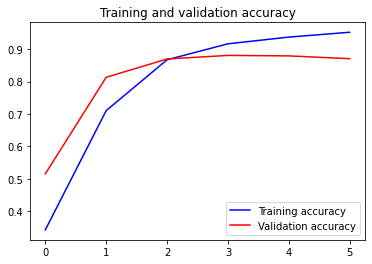

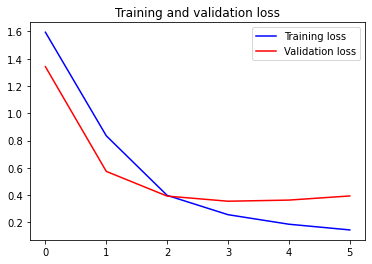

In [39]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=range(len(accuracy))

plt.plot(epochs,accuracy,'b', label='Training accuracy')
plt.plot(epochs,val_acc,'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
def sentence_cleaning(sentence):
    """Pre-processing sentence for prediction"""
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    return pad

In [48]:
sentences = [
            "After playing baseball , I was excited to go .",
            "After loosing the game he was sad",
            "I was angry by your play ",
            "You are a person of good vibes"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

After playing baseball , I was excited to go .
joy : 0.8553478121757507


After loosing the game he was sad
sadness : 0.5508908033370972


I was angry by your play 
anger : 0.7594534158706665


You are a person of good vibes
joy : 0.5346478819847107


